<a href="https://colab.research.google.com/github/FatherOfLove/AdvancedDeepLearning/blob/master/Assignment1_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wHpqdSNDcjnTw9tDUH2hRCV3XGRQsy0gfFv7UIEy6rimLwEgj2m5Xg
Mounted at /content/drive


In [48]:
import os
import datetime
import copy
import re
import yaml
import uuid
import warnings
import time
import inspect

import numpy as np
import pandas as pd
from functools import partial, reduce
from random import shuffle
import random

import torch
from torch import nn, optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from torchvision.models import resnet
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
import tensorflow as tf
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics as mtx
from sklearn import model_selection as ms

In [15]:
train_label = ("/content/drive/My Drive/Data set/MNIST/train-labels.idx1-ubyte")
train_images = ("/content/drive/My Drive/Data set/MNIST/train-images.idx3-ubyte")
test_label = ("/content/drive/My Drive/Data set/MNIST/t10k-labels.idx1-ubyte")
test_images = ("/content/drive/My Drive/Data set/MNIST/t10k-images.idx3-ubyte")

In [16]:
train_label

'/content/drive/My Drive/Data set/MNIST/train-labels.idx1-ubyte'

In [17]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert(train_images,train_label,
        "mnist_train.csv", 60000)
convert(test_images, test_label,
        "mnist_test.csv", 10000)

In [27]:
df_train = pd.read_csv("/content/drive/My Drive/Data set/MNIST/mnist_train.csv")
df_train.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590,0.591,0.592,0.593,0.594,0.595,0.596,0.597,0.598,0.599,0.600,0.601,0.602,0.603,0.604,0.605,0.606,0.607,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df_train.tail()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590,0.591,0.592,0.593,0.594,0.595,0.596,0.597,0.598,0.599,0.600,0.601,0.602,0.603,0.604,0.605,0.606,0.607,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
59994,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59995,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59996,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59997,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
df_train['5'].value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5420
Name: 5, dtype: int64

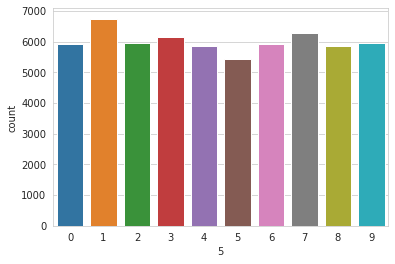

In [38]:
sns.set_style('whitegrid')
sns.countplot(x = '5', data = df_train)

In [28]:
df_test = pd.read_csv("/content/drive/My Drive/Data set/MNIST/mnist_test.csv")
df_test.head()

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.628,0.629,0.630,0.631,0.632,0.633,0.634,0.635,0.636,0.637,0.638,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648,0.649,0.650,0.651,0.652,0.653,0.654,0.655,0.656,0.657,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
df_test['7'].value_counts()

1    1135
2    1032
7    1027
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: 7, dtype: int64

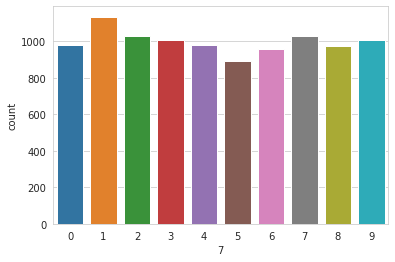

In [39]:
sns.set_style('whitegrid')
sns.countplot(x = '7', data = df_test)

In [40]:
df_features = df_train.iloc[:, 1:785]
df_label = df_train.iloc[:, 0]

X_test = df_test.iloc[:, 0:784]

print(X_test.shape)

(9999, 784)


In [46]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(df_features, df_label, 
                                                test_size = 0.2,
                                                random_state = 1212)

X_train = X_train.values.reshape(33600, 784) #(33600, 784)
X_cv = X_cv.as_matrix().reshape(8400, 784) #(8400, 784)

X_test = X_test.as_matrix().reshape(9999, 784)

ValueError: ignored

In [52]:
def get_data_loaders(train_batch_size, val_batch_size):
    mnist = MNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = Compose([ Resize((224, 224)),ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])

    train_loader = DataLoader(MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(MNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [55]:
train_batch_size = 256
val_batch_size = 256

train_loader, valid_loader = get_data_loaders(train_batch_size, val_batch_size)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [53]:
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)

In [56]:
start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# model:
model = MnistResNet().to(device)

# params you need to specify:
epochs = 5
train_loader, val_loader = get_data_loaders(train_batch_size, val_batch_size)
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, I've used Adadelta, as it wokrs well without any magic numbers
optimizer = optim.Adadelta(model.parameters())


losses = []
batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        # training step for single batch
        model.zero_grad() # to make sure that all the grads are 0 
        """
        model.zero_grad() and optimizer.zero_grad() are the same 
        IF all your model parameters are in that optimizer. 
        I found it is safer to call model.zero_grad() to make sure all grads are zero, 
        e.g. if you have two or more optimizers for one model.

        """
        outputs = model(X) # forward
        loss = loss_function(outputs, y) # get loss
        loss.backward() # accumulates the gradient (by addition) for each parameter.
        optimizer.step() # performs a parameter update based on the current gradient 

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


NameError: ignored

In [57]:
torch.save(model.state_dict(), 'mnist_state.pt')

In [58]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [59]:
x_train.shape

(60000, 28, 28)

In [60]:
x_train = x_train[:30001]
y_train = y_train[:30001]
x_test = x_test[:9000]
y_test = y_test[:9000]

In [61]:

# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (30001, 28, 28)
Number of images in x_train 30001
Number of images in x_test 9000


In [62]:
instance_index_label = [(i, y_train[i]) for i in range(x_train.shape[0])]
instance_index_label_test = [(i, y_test[i]) for i in range(x_test.shape[0])]

In [63]:
# find the index if label is 1
find_index = [instance_index_label[i][0] for i in range(len(instance_index_label)) if instance_index_label[i][1]==1]
# find the index if label is 1
find_index_test = [instance_index_label_test[i][0] for i in range(len(instance_index_label_test))
                   if instance_index_label_test[i][1]==1]

In [64]:
print('index:', instance_index_label[0][0]) #index
print('label:', instance_index_label[0][1]) #label

index: 0
label: 5


In [65]:
import torch
from torchvision.models.resnet import ResNet, BasicBlock
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)

In [66]:
model = MnistResNet()
model.load_state_dict(torch.load('mnist_state.pt'))
body = nn.Sequential(*list(model.children()))
# extract the last layer
model = body[:9]
# the model we will use
model.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [67]:
train_batch_size = 1
val_batch_size = 1
train_loader, val_loader = get_data_loaders(train_batch_size, val_batch_size)
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer
optimizer = optim.Adadelta(model.parameters())

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [68]:
losses = []
batches = len(train_loader)
val_batches = len(val_loader)

In [69]:

# loop for every epoch (training + evaluation)
meta_table = dict()
feature_result = []

# progress bar
progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

model.eval()

for i, data in progress:
    if i==30001:
        break
    X, y = data[0], data[1]
    # training step for single batch
    model.zero_grad()
    outputs = model(X)
    feature_result.append(outputs.reshape(-1).tolist())
    meta_table[i] = outputs.reshape(-1).tolist()
    
feature_array = np.array(feature_result)
np.save('feature_array_full',feature_array )

In [70]:
# load
feature_array = np.load('feature_array.npy', allow_pickle=True)

FileNotFoundError: ignored

In [71]:
from torch.utils.data import Dataset
class Transform_data(Dataset):
    """
    We want to 1. pad tensor 2. transform the data to the size that fits in the input size.
    
    """

    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = data
        
    def __getitem__(self, index):
        tensor = self.data[index][0]
        if self.transform is not None:
            tensor = self.transform(tensor)
        return (tensor, self.data[index][1])

    def __len__(self):
        return len(self.data)

In [72]:

train_data = [(bag_features[i],bag_labels[i]) for i in range(len(bag_features))]

NameError: ignored

In [73]:
bag_features[0]

NameError: ignored

In [74]:
def pad_tensor(data:list, max_number_instance) -> list:
    """
    Since our bag has different sizes, we need to pad each tensor to have the same shape (max: 7).
    We will look through each one instance and look at the shape of the tensor, and then we will pad 7-n 
    to the existing tensor where n is the number of instances in the bag.
    The function will return a padded data set."""
    new_data = []
    for bag_index in range(len(data)):
        tensor_size = len(data[bag_index][0])
        pad_size = max_number_instance - tensor_size
        p2d = (0,0, 0, pad_size)
        padded = nn.functional.pad(data[bag_index][0], p2d, 'constant', 0)
        new_data.append((padded, data[bag_index][1]))
    return new_data

In [75]:
max_number_instance = 7
padded_train = pad_tensor(train_data, max_number_instance)

NameError: ignored

In [ ]:

test_data = [(bag_t_features[i],bag_t_labels[i]) for i in range(len(bag_t_features))]
padded_test = pad_tensor(test_data, max_number_instance)

In [ ]:
def get_data_loaders(train_data, test_data, train_batch_size, val_batch_size):
    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [ ]:
train_loader,valid_loader = get_data_loaders(padded_train, padded_test, 1, 1)

In [76]:

train_batch_size = 1
val_batch_size = 1

In [77]:

# aggregation functions

class SoftMaxMeanSimple(torch.nn.Module):
    def __init__(self, n, n_inst, dim=0):
        """
        if dim==1:
            given a tensor `x` with dimensions [N * M],
            where M -- dimensionality of the featur vector
                       (number of features per instance)
                  N -- number of instances
            initialize with `AggModule(M)`
            returns:
            - weighted result: [M]
            - gate: [N]
        if dim==0:
            ...
        """
        super(SoftMaxMeanSimple, self).__init__()
        self.dim = dim
        self.gate = torch.nn.Softmax(dim=self.dim)      
        self.mdl_instance_transform = nn.Sequential(
                            nn.Linear(n, n_inst),
                            nn.LeakyReLU(),
                            nn.Linear(n_inst, n),
                            nn.LeakyReLU(),
                            )
    def forward(self, x):
        z = self.mdl_instance_transform(x)
        if self.dim==0:
            z = z.view((z.shape[0],1)).sum(1)
        elif self.dim==1:
            z = z.view((1, z.shape[1])).sum(0)
        gate_ = self.gate(z)
        res = torch.sum(x* gate_, self.dim)
        return res, gate_

    
class AttentionSoftMax(torch.nn.Module):
    def __init__(self, in_features = 3, out_features = None):
        """
        given a tensor `x` with dimensions [N * M],
        where M -- dimensionality of the featur vector
                   (number of features per instance)
              N -- number of instances
        initialize with `AggModule(M)`
        returns:
        - weighted result: [M]
        - gate: [N]
        """
        super(AttentionSoftMax, self).__init__()
        self.otherdim = ''
        if out_features is None:
            out_features = in_features
        self.layer_linear_tr = nn.Linear(in_features, out_features)
        self.activation = nn.LeakyReLU()
        self.layer_linear_query = nn.Linear(out_features, 1)
        
    def forward(self, x):
        keys = self.layer_linear_tr(x)
        keys = self.activation(keys)
        attention_map_raw = self.layer_linear_query(keys)[...,0]
        attention_map = nn.Softmax(dim=-1)(attention_map_raw)
        result = torch.einsum(f'{self.otherdim}i,{self.otherdim}ij->{self.otherdim}j', attention_map, x)
        return result, attention_map